# Data Preprocessing

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [8]:
df = pd.read_csv("../data/sba_national.csv", low_memory=False)
print(df.shape)
df.sample(3)

(899164, 27)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
434871,4216515010,BJ's Enterprises,LEAGUE CITY,TX,77573,JPMORGAN CHASE BANK NATL ASSOC,IL,561730,19-Aug-10,2010,...,Y,N,NaN,19-Aug-10,"$41,650.00",$0.00,P I F,$0.00,"$25,000.00","$12,500.00"
283756,2965216008,BAKLUND TOOL & DESIGN INC,HUTCHINSON,MN,55350,CITIZENS BANK & TRUST CO,MN,332721,30-Aug-07,2007,...,0,N,NaN,31-Oct-07,"$220,000.00",$0.00,P I F,$0.00,"$220,000.00","$110,000.00"
638929,6361464007,JON SUDDUTH ELECTRICAL SERVICE,ONTARIO,CA,91761,CALIFORNIA BANK & TRUST,CA,238210,30-May-03,2003,...,Y,N,4-May-10,30-Jun-03,"$50,148.00",$0.00,CHGOFF,"$48,954.00","$50,000.00","$25,000.00"


## Data Validation

In [9]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

### LoanNr_ChkDgt, Name, City, Zip, Bank, FranchiseCode, BalanceGross, ChgOffDate & ChgOffPrinGr

In [10]:
drop_cols = ["LoanNr_ChkDgt",   # tiene 100% de valores distintos
             "Name",            # tiene 86.7% de valores distintos
             "City",            # cuenta con 32581 ciudades diferentes
             "Zip",             # cuenta con 33611 codigos postales diferentes
             "Bank",            # cuenta con 5802 bancos diferentes
             "FranchiseCode",   # tiene 94.2% de codigos sin franquicia
             "BalanceGross",    # tiene practicamente 100% de valores en cero
             "ChgOffDate",      # fuga de informacion de la variable objetivo
             "ChgOffPrinGr"]    # fuga de informacion de la variable objetivo

In [11]:
df.drop(drop_cols, axis=1, inplace=True)
df.shape

(899164, 18)

### ApprovalDate, ApprovalFY & DisbursementDate

In [12]:
drop_cols = ["ApprovalDate",    # comportamiento similar a DisbursementDate
             "ApprovalFY"]      # comportamiento similar a DisbursementDate

In [13]:
# remplazamos las fechas de desembolsos nulas por las fechas de aprobacion
df["DisbursementDate"] = np.where(df["DisbursementDate"].isnull(), df["ApprovalDate"], df["DisbursementDate"])

In [14]:
# formateamos la fecha debido a que el año tiene solamente dos digitos
def format_date(app_date):
    date = app_date.split("-")
    year = date[2]
    if int(year) > 14: year = "19" + year
    else: year = "20" + year
    return f"{date[0]}-{date[1]}-{year}"

df["DisbursementDate"] = pd.to_datetime(df["DisbursementDate"].apply(format_date))

In [15]:
df.drop(drop_cols, axis=1, inplace=True)
df.shape

(899164, 16)

### State, BankState, Term, NoEmp, CreateJob, RetainedJob & UrbanRural

In [16]:
df["State"].unique()

array(['IN', 'OK', 'FL', 'CT', 'NJ', 'NC', 'IL', 'RI', 'TX', 'VA', 'TN',
       'AR', 'MN', 'MO', 'MA', 'CA', 'SC', 'LA', 'IA', 'OH', 'KY', 'MS',
       'NY', 'MD', 'PA', 'OR', 'ME', 'KS', 'MI', 'AK', 'WA', 'CO', 'MT',
       'WY', 'UT', 'NH', 'WV', 'ID', 'AZ', 'NV', 'WI', 'NM', 'GA', 'ND',
       'VT', 'AL', 'NE', 'SD', 'HI', 'DE', 'DC', nan], dtype=object)

In [17]:
df["BankState"].unique()

array(['OH', 'IN', 'OK', 'FL', 'DE', 'SD', 'AL', 'CT', 'GA', 'OR', 'MN',
       'RI', 'NC', 'TX', 'MD', 'NY', 'TN', 'SC', 'MS', 'MA', 'LA', 'IA',
       'VA', 'CA', 'IL', 'KY', 'PA', 'MO', 'WA', 'MI', 'UT', 'KS', 'WV',
       'WI', 'AZ', 'NJ', 'CO', 'ME', 'NH', 'AR', 'ND', 'MT', 'ID', nan,
       'WY', 'NM', 'DC', 'NV', 'NE', 'PR', 'HI', 'VT', 'AK', 'GU', 'AN',
       'EN', 'VI'], dtype=object)

In [18]:
df["Term"].value_counts()

Term
84     230162
60      89945
240     85982
120     77654
300     44727
        ...  
438         1
382         1
367         1
374         1
429         1
Name: count, Length: 412, dtype: int64

In [19]:
df["NoEmp"].value_counts()

NoEmp
1       154254
2       138297
3        90674
4        73644
5        60319
         ...  
414          1
604          1
1280         1
3089         1
3713         1
Name: count, Length: 599, dtype: int64

In [20]:
df["CreateJob"].value_counts()

CreateJob
0      629248
1       63174
2       57831
3       28806
4       20511
        ...  
171         1
146         1
214         1
179         1
860         1
Name: count, Length: 246, dtype: int64

In [21]:
df["RetainedJob"].value_counts()

RetainedJob
0      440403
1       88790
2       76851
3       49963
4       39666
        ...  
191         1
247         1
226         1
675         1
198         1
Name: count, Length: 358, dtype: int64

In [22]:
df["UrbanRural"].value_counts()

UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

### DisbursementGross, GrAppv & SBA_Appv

In [23]:
# DisbursementGross: formateamos la variable de currency a entero
df["DisbursementGross"] = df["DisbursementGross"].str.replace(r"[\$,]", "", regex=True).astype(float)
df["DisbursementGross"] = df["DisbursementGross"].round().astype(int)
df["DisbursementGross"].value_counts()

DisbursementGross
50000      43787
100000     36714
25000      27387
150000     23373
10000      21328
           ...  
143118         1
23827          1
157338         1
60698          1
1086300        1
Name: count, Length: 118859, dtype: int64

In [24]:
# GrAppv: formateamos la variable de currency a entero
df["GrAppv"] = df["GrAppv"].str.replace(r"[\$,]", "", regex=True).astype(float)
df["GrAppv"] = df["GrAppv"].round().astype(int)
df["GrAppv"].value_counts()

GrAppv
50000      69394
25000      51258
100000     50977
10000      38366
150000     27624
           ...  
407542         1
220900         1
57587          1
531577         1
1086300        1
Name: count, Length: 22128, dtype: int64

In [25]:
# SBA_Appv: formateamos la variable de currency a entero
df["SBA_Appv"] = df["SBA_Appv"].str.replace(r"[\$,]", "", regex=True).astype(float)
df["SBA_Appv"] = df["SBA_Appv"].round().astype(int)
df["SBA_Appv"].value_counts()

SBA_Appv
25000     49579
12500     40147
5000      31135
50000     25047
10000     17009
          ...  
192949        1
212352        1
57072         1
32938         1
715674        1
Name: count, Length: 38326, dtype: int64

### NAICS

In [26]:
sector = {"11":"Agriculture, forestry, fishing and hunting",
          "21":"Mining, quarrying, and oil and gas extraction",
          "22":"Utilities",
          "23":"Construction",
          "31":"Manufacturing",
          "32":"Manufacturing",
          "33":"Manufacturing",
          "42":"Wholesale trade",
          "44":"Retail trade",
          "45":"Retail trade",
          "48":"Transportation and warehousing",
          "49":"Transportation and warehousing",
          "51":"Information",
          "52":"Finance and insurance",
          "53":"Real estate and rental and leasing",
          "54":"Professional, scientific, and technical services",
          "55":"Management of companies and enterprises",
          "56":"Administrative and support and waste management and remediation services",
          "61":"Educational services",
          "62":"Health care and social assistance",
          "71":"Arts, entertainment, and recreation",
          "72":"Accommodation and food services",
          "81":"Other services (except public administration)",
          "92":"Public administration",
          "0":"[Unallocated sector]"} # creamos la categoria "sector no asignado"}

In [27]:
# asignamos a NAICS el nombre del sector correspondiente
df["NAICS"] = df["NAICS"].astype(str).str[0:2]
df["NAICS"] = df["NAICS"].apply(lambda x: sector[x])
df["NAICS"]

0                              Retail trade
1           Accommodation and food services
2         Health care and social assistance
3                      [Unallocated sector]
4                      [Unallocated sector]
                        ...                
899159                         Retail trade
899160                         Retail trade
899161                        Manufacturing
899162                 [Unallocated sector]
899163                 [Unallocated sector]
Name: NAICS, Length: 899164, dtype: object

### NewExist, RevLineCr & LowDoc

In [28]:
# NewExist: convertimos a NaN los valores no definidos
df["NewExist"] = np.where(df["NewExist"]==0.0, np.nan, df["NewExist"])
df["NewExist"] = df["NewExist"].astype("Int64")
df["NewExist"].value_counts()

NewExist
1    644869
2    253125
Name: count, dtype: Int64

In [29]:
# RevLineCr: convertimos a enteros los valores definidos y a NaN los demas
# asumiremos que T (true) y 1 podrian ser Y (yes), y 0 podria ser N (no)
df["RevLineCr"] = np.where(df["RevLineCr"].isin(["Y","T"]), "1", df["RevLineCr"])
df["RevLineCr"] = np.where(df["RevLineCr"].isin(["N"]), "0", df["RevLineCr"])
df["RevLineCr"] = np.where(~df["RevLineCr"].isin(["1","0"]), np.nan, df["RevLineCr"])
df["RevLineCr"] = df["RevLineCr"].astype("Int64")
df["RevLineCr"].value_counts()

RevLineCr
0    677890
1    216704
Name: count, dtype: Int64

In [30]:
# LowDoc: convertimos a enteros los valores definidos y a NaN los demas
# asumiremos que 1 podria ser Y (yes), y que 0 podria ser N (no)
df["LowDoc"] = np.where(df["LowDoc"]=="Y", "1", df["LowDoc"])
df["LowDoc"] = np.where(df["LowDoc"]=="N", "0", df["LowDoc"])
df["LowDoc"] = np.where(~df["LowDoc"].isin(["1","0"]), np.nan, df["LowDoc"])
df["LowDoc"] = df["LowDoc"].astype("Int64")
df["LowDoc"].value_counts()

LowDoc
0    784313
1    110336
Name: count, dtype: Int64

### MIS_Status

In [31]:
# MIS_Status: convertimos los valores a enteros (1 = Default y 0 = Paid)
df["MIS_Status"] = np.where(df["MIS_Status"]=="CHGOFF", 1, df["MIS_Status"])
df["MIS_Status"] = np.where(df["MIS_Status"]=="P I F", 0, df["MIS_Status"])
df["MIS_Status"] = df["MIS_Status"].astype("Int64")
df["MIS_Status"].value_counts()

MIS_Status
0    739609
1    157558
Name: count, dtype: Int64

### Drop Duplicates

In [32]:
# adicionalmente se visualizan y eliminan las instancias duplicadas
print(df[df.duplicated].shape)
display(df[df.duplicated].sample(3))

df.drop_duplicates(inplace=True)

(1829, 16)


,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,GrAppv,SBA_Appv
602349,NY,NY,[Unallocated sector],84,1,1,0,0,0,0,0,1994-04-30,50000,0,50000,45000
721336,PA,RI,Health care and social assistance,84,3,1,0,3,1,1,0,2008-12-31,5000,0,5000,2500
643843,CT,RI,"Professional, scientific, and technical services",84,1,1,0,1,1,1,0,2003-07-31,5000,0,5000,2500


In [33]:
print(df.shape)
df.dtypes

(897335, 16)


State                        object
BankState                    object
NAICS                        object
Term                          int64
NoEmp                         int64
NewExist                      Int64
CreateJob                     int64
RetainedJob                   int64
UrbanRural                    int64
RevLineCr                     Int64
LowDoc                        Int64
DisbursementDate     datetime64[ns]
DisbursementGross             int64
MIS_Status                    Int64
GrAppv                        int64
SBA_Appv                      int64
dtype: object

## Missing Values

In [34]:
df.isnull().sum()

State                  14
BankState            1562
NAICS                   0
Term                    0
NoEmp                   0
NewExist             1169
CreateJob               0
RetainedJob             0
UrbanRural              0
RevLineCr            4566
LowDoc               4512
DisbursementDate        0
DisbursementGross       0
MIS_Status           1951
GrAppv                  0
SBA_Appv                0
dtype: int64

### Using FillNA and DropNA

In [35]:
# imputamos los valores faltantes con la moda de la variable
mode = df["State"].mode()[0]
df["State"] = df["State"].fillna(mode)

In [36]:
# eliminamos todas las instancias nulas de la variable objetivo
df.dropna(subset=["MIS_Status"], inplace=True)
df["MIS_Status"] = df["MIS_Status"].astype(int)
df.shape

(895384, 16)

### Univariant: Simple Imputer

In [37]:
# imputamos los valores faltantes con la moda de la variable
col_values = df[["BankState"]]
mode_imputer = SimpleImputer(strategy="most_frequent")
mode_imputer_fit = mode_imputer.fit(col_values)
df["BankState"] = mode_imputer_fit.transform(col_values)[:, 0]

### Multivariant: KNN Imputer

In [38]:
# aplicamos imputacion multivariante de faltantes con KNN Imputer
cols_fit = df[["NewExist", "Term", "NoEmp", "CreateJob", "RetainedJob",
               "UrbanRural", "DisbursementGross", "GrAppv", "SBA_Appv"]]
k = int(round(np.sqrt(df.shape[0]), 2))
knn_imputer = KNNImputer(n_neighbors=k)
knn_imputer_fit = knn_imputer.fit(cols_fit)

cols_imputed = knn_imputer_fit.transform(cols_fit)
df["NewExist"] = cols_imputed[:, 0]

df["NewExist"] = round(df["NewExist"]).astype(int)
df["NewExist"].value_counts()

NewExist
1    643218
2    252166
Name: count, dtype: int64

### Using Classification Models

In [39]:
# imputamos valores categoricos faltantes utilizando modelos de clasificacion
cols = ["RevLineCr", "LowDoc"]
for col in cols:
    df_ = df[[col, "Term", "NoEmp", "CreateJob", "RetainedJob",
              "UrbanRural", "DisbursementGross", "GrAppv", "SBA_Appv"]]

    df_train = df_.dropna(subset=[col])
    df_test = df_[df_[col].isnull()]

    X_train = df_train.drop(columns=[col])
    y_train = df_train[col]
    X_test = df_test.drop(columns=[col])

    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)

    y_test = rf_classifier.predict(X_test)
    df.loc[df[col].isnull(), col] = y_test

    df[col] = df[col].astype(int)
    print(f"{col}:")
    print(f"{df[col].value_counts()}\n")

RevLineCr:
RevLineCr
0    680152
1    215232
Name: count, dtype: int64

LowDoc:
LowDoc
0    785451
1    109933
Name: count, dtype: int64



In [40]:
print(df.shape)
df.isnull().sum()

(895384, 16)


State                0
BankState            0
NAICS                0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
MIS_Status           0
GrAppv               0
SBA_Appv             0
dtype: int64

## Outlier Detection

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 895384 entries, 0 to 899163
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   State              895384 non-null  object        
 1   BankState          895384 non-null  object        
 2   NAICS              895384 non-null  object        
 3   Term               895384 non-null  int64         
 4   NoEmp              895384 non-null  int64         
 5   NewExist           895384 non-null  int64         
 6   CreateJob          895384 non-null  int64         
 7   RetainedJob        895384 non-null  int64         
 8   UrbanRural         895384 non-null  int64         
 9   RevLineCr          895384 non-null  int64         
 10  LowDoc             895384 non-null  int64         
 11  DisbursementDate   895384 non-null  datetime64[ns]
 12  DisbursementGross  895384 non-null  int64         
 13  MIS_Status         895384 non-null  int64        

### Z-Score

In [42]:
# usamos la desviacion estandar y Z-score con umbral de 3 para detectar outliers
cols = ["Term", "NoEmp"]
for col in cols:
    media = df[col].mean()
    dest = df[col].std()
    umbral = 3

    z_scores = (df[col] - media) / dest
    df = df[(z_scores.abs() <= umbral)]

    print(f"{col}:")
    print(f"Media: {round(media, 1)}")
    print(f"Desviacion: {round(dest, 1)}")
    print(f"Limite Max: {round(media + (dest * umbral), 1)}")
    print(f"Outliers: {z_scores[z_scores > umbral].count()}\n")

print(df.shape)

Term:
Media: 110.9
Desviacion: 78.9
Limite Max: 347.7
Outliers: 183

NoEmp:
Media: 11.4
Desviacion: 73.9
Limite Max: 233.0
Outliers: 1444

(893757, 16)


### Interquartile Range

In [43]:
# usamos el rango intercuartilico IQR multiplicado con 7.5 como factor de escala
Q1 = df["DisbursementGross"][df["DisbursementGross"] > 0].quantile(0.25)
Q3 = df["DisbursementGross"][df["DisbursementGross"] > 0].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 7.5* IQR
outliers = df[(df["DisbursementGross"] < limite_inferior) | (df["DisbursementGross"] > limite_superior)].shape[0]

df = df[(df["DisbursementGross"] >= limite_inferior) & (df["DisbursementGross"] <= limite_superior)]

print(f"Rango Intercuartilico: {round(IQR, 1)}")
print(f"Limite Inferior: {round(limite_inferior, 1)}")
print(f"Limite Superior: {round(limite_superior, 1)}")
print(f"Outliers: {outliers}")
print(df.shape)

Rango Intercuartilico: 195500.0
Limite Inferior: -250750.0
Limite Superior: 1704250.0
Outliers: 4073
(889684, 16)


### Elliptic Envelope

In [44]:
# aplicamos el ajuste de una envolvente eliptica para datos multivariados
df_ = df[["GrAppv","SBA_Appv"]].copy()
# model_outlier = IsolationForest(contamination=0.01)
model_outlier = EllipticEnvelope(contamination=0.01)
model_outlier.fit(df_)

outliers = model_outlier.predict(df_)
df_["Outlier"] = np.where(outliers == -1, 1, 0)
df = df[df_["Outlier"] == 0]

out_count = df_[df_["Outlier"]==1].shape[0]
print(f"Outliers: {out_count}")
print(df.shape)

Outliers: 8897
(880787, 16)


In [45]:
print(df.shape)
df.sample(3)

(880787, 16)


,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,GrAppv,SBA_Appv
160483,CA,CA,Finance and insurance,84,1,1,0,1,1,0,0,2006-12-31,5000,0,5000,4250
857813,CA,CA,[Unallocated sector],240,46,1,38,8,0,0,0,1997-02-12,750000,0,750000,750000
166978,NY,NY,[Unallocated sector],240,19,1,7,12,0,0,0,1999-07-14,235000,0,235000,235000


## Feature Engineering

### Create Features

In [46]:
# creamos una variable que define si State y BankState son similares
df["StateDiff"] = np.where(df["State"] != df["BankState"], 1, 0)

In [47]:
# cambiamos de nombre la variable NAICS a Sector que la describe mejor
df.rename(columns={"NAICS":"Sector"}, inplace=True)

In [48]:
# escalamos los valores de la variable NewExist a valores binarios
df["NewExist"] = np.where(df["NewExist"] == 2, 1, 0)

In [49]:
# calculamos si el prestamo esta garantizado con una propiedad inmobiliaria
df["SecuredLoan"] = np.where(df["Term"] >= 240, 1, 0)

In [44]:
# calculamos la fecha de vencimiento sumando Term a DisbursementDate
# df["ExpirationDate"] = df.apply(lambda x: x["DisbursementDate"]
#                                 + pd.DateOffset(months=x["Term"]), axis=1)

In [50]:
# creamos variables para el año y mes de la variable DisbursementDate
df["DisbursementYear"] = df["DisbursementDate"].dt.year
df["DisbursementMonth"] = df["DisbursementDate"].dt.month

In [51]:
# cambiamos de nombre las variables de Disbursement por una abreviacion
df.rename(columns={"DisbursementYear":"DisbYear",
                   "DisbursementMonth":"DisbMonth",
                   "DisbursementGross":"DisbGross"}, inplace=True)

In [52]:
# calculamos el porcentaje del monto de SBA_Appv aportado sobre GrAppv
df["SBA_Secured"] = round((df["SBA_Appv"] / df["GrAppv"]) * 100)
df["SBA_Secured"] = df["SBA_Secured"].astype(int)

In [53]:
# cambiamos de nombre la variable MIS_Status a Default que la describe mejor
df.rename(columns={"MIS_Status":"Default"}, inplace=True)

In [54]:
# ordenamos adecuadamente todas las variables actuales del dataset
df = df[["State","BankState","StateDiff","Sector","Term","SecuredLoan","NoEmp",
         "NewExist","CreateJob","RetainedJob","UrbanRural","RevLineCr","LowDoc",
         "DisbYear","DisbMonth", "DisbGross","GrAppv","SBA_Appv","SBA_Secured","Default"]]

In [55]:
print(df.shape)
df.sample(3)

(880787, 20)


,State,BankState,StateDiff,Sector,Term,SecuredLoan,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
19966,IL,VA,1,Retail trade,90,0,10,0,0,10,1,0,0,2005,1,50000,50000,25000,50,0
504694,KY,KY,0,Manufacturing,120,0,25,0,0,0,0,0,0,1992,7,400000,400000,324000,81,0
35273,OK,OK,0,[Unallocated sector],72,0,6,0,0,0,0,0,0,1997,8,175000,175000,131250,75,1


### Feature Analisys

In [56]:
# verificamos que todos los tipos de datos del dataset sean correctos
df.dtypes

State          object
BankState      object
StateDiff       int64
Sector         object
Term            int64
SecuredLoan     int64
NoEmp           int64
NewExist        int64
CreateJob       int64
RetainedJob     int64
UrbanRural      int64
RevLineCr       int64
LowDoc          int64
DisbYear        int32
DisbMonth       int32
DisbGross       int64
GrAppv          int64
SBA_Appv        int64
SBA_Secured     int64
Default         int64
dtype: object

In [57]:
# separamos en listas las variables binarias, numericas y categoricas
bin_cols = ["StateDiff","SecuredLoan","NewExist",
            "RevLineCr","LowDoc","Default"]         # binarias

num_cols = ["Term","NoEmp","CreateJob",
            "RetainedJob","SBA_Secured",            # numericas discretas
            "DisbGross","GrAppv","SBA_Appv"]        # numericas continuas

cat_cols = ["State","BankState","Sector",           # categoricas nominales
            "UrbanRural",                           # categoricas numericas
            "DisbYear","DisbMonth"]                 # categoricas ordinales

# _ = df.select_dtypes("int").columns.to_list()
print(f"Binary:    {bin_cols}")
print(f"Numeric:   {num_cols}")
print(f"Categoric: {cat_cols}")

Binary:    ['StateDiff', 'SecuredLoan', 'NewExist', 'RevLineCr', 'LowDoc', 'Default']
Numeric:   ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'SBA_Secured', 'DisbGross', 'GrAppv', 'SBA_Appv']
Categoric: ['State', 'BankState', 'Sector', 'UrbanRural', 'DisbYear', 'DisbMonth']


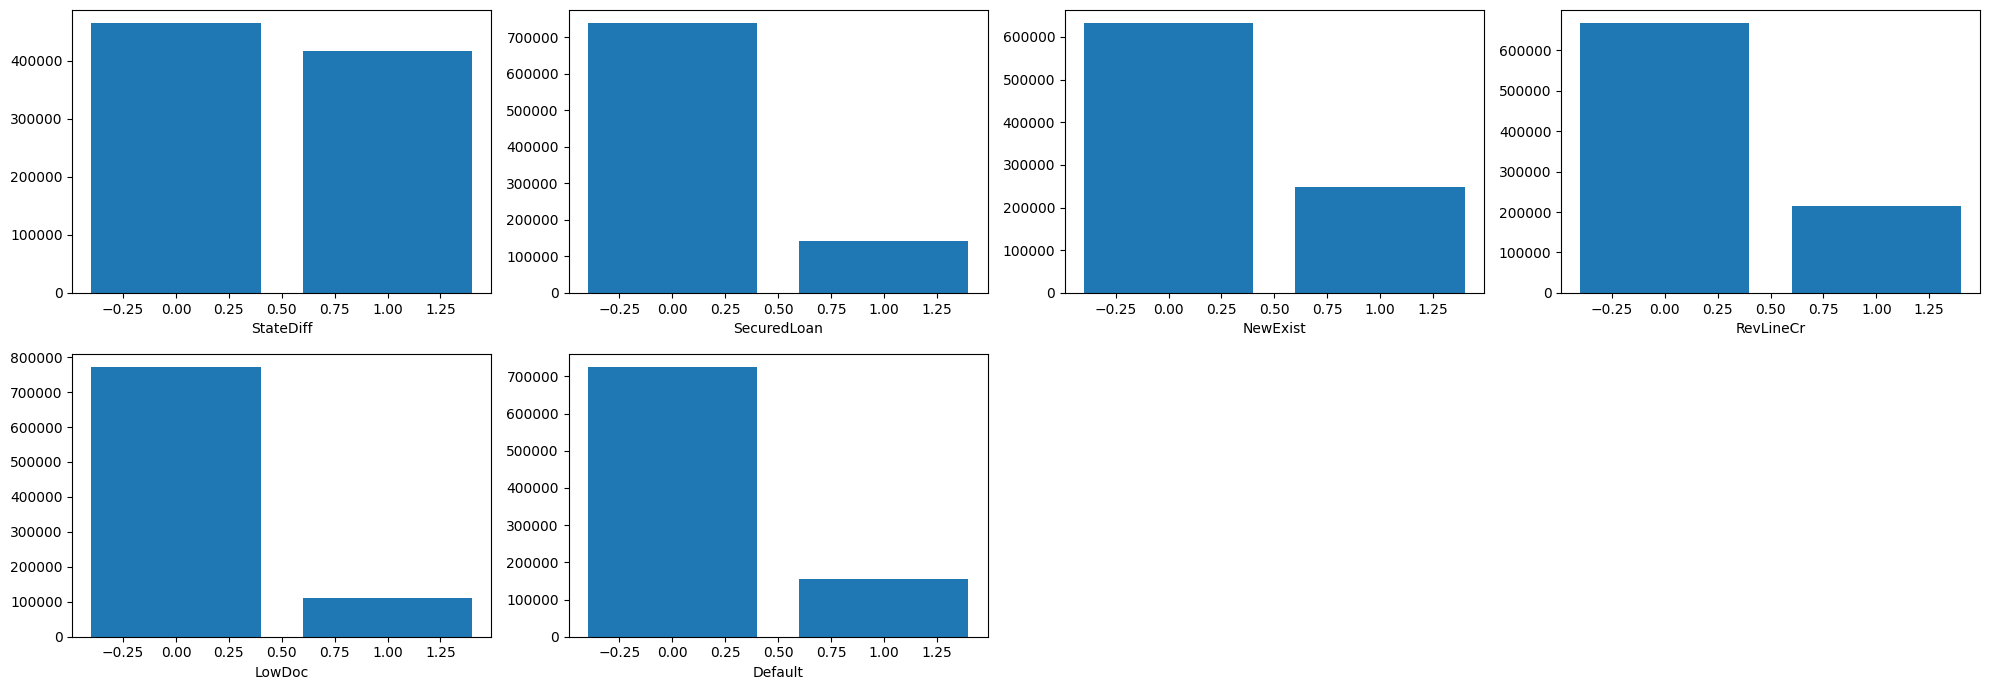

In [58]:
# graficamos la distribucion de los datos de las variables binarias
plt.figure(figsize=(20,7))
n_rows, n_cols = 2, 4

for num, col in enumerate(bin_cols):
    plt.subplot(n_rows, n_cols, num + 1)
    df_ = df.groupby(col)[col].count().reset_index(name="count")
    plt.bar(df_[col], df_["count"])
    plt.xlabel(col)

plt.tight_layout()
plt.show()

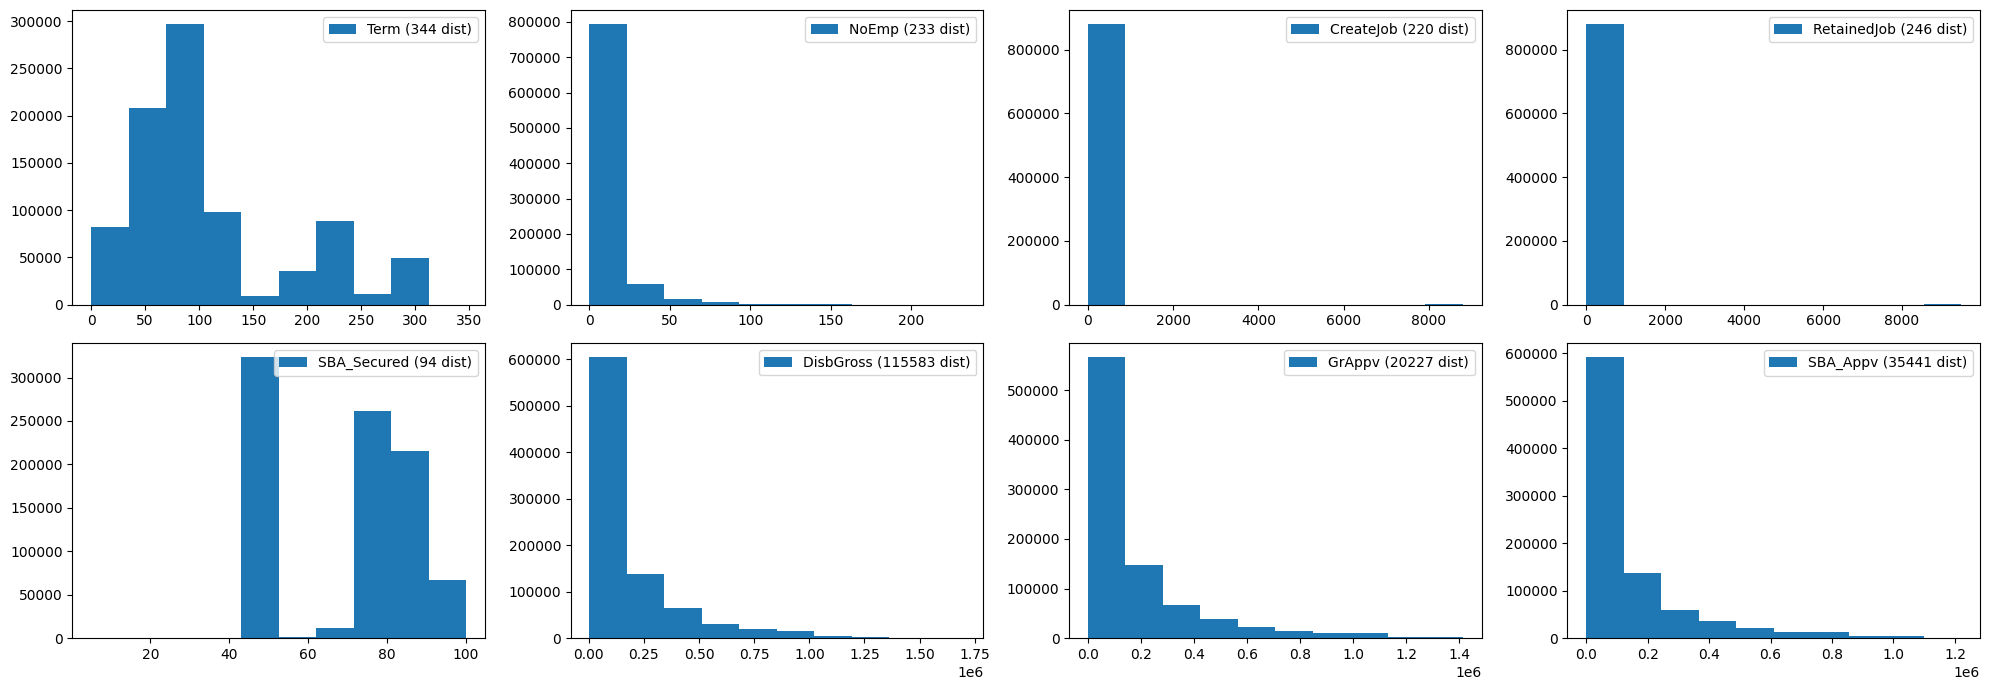

In [59]:
# graficamos la distribucion de los datos de las variables numericas
plt.figure(figsize=(20,7))
n_rows, n_cols = 2, 4

for num, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, num + 1)
    col_cls = col + " (" + str(df[col].value_counts().count()) + " dist)"
    plt.hist(df[col], label=col_cls)
    plt.legend()

plt.tight_layout()
plt.show()

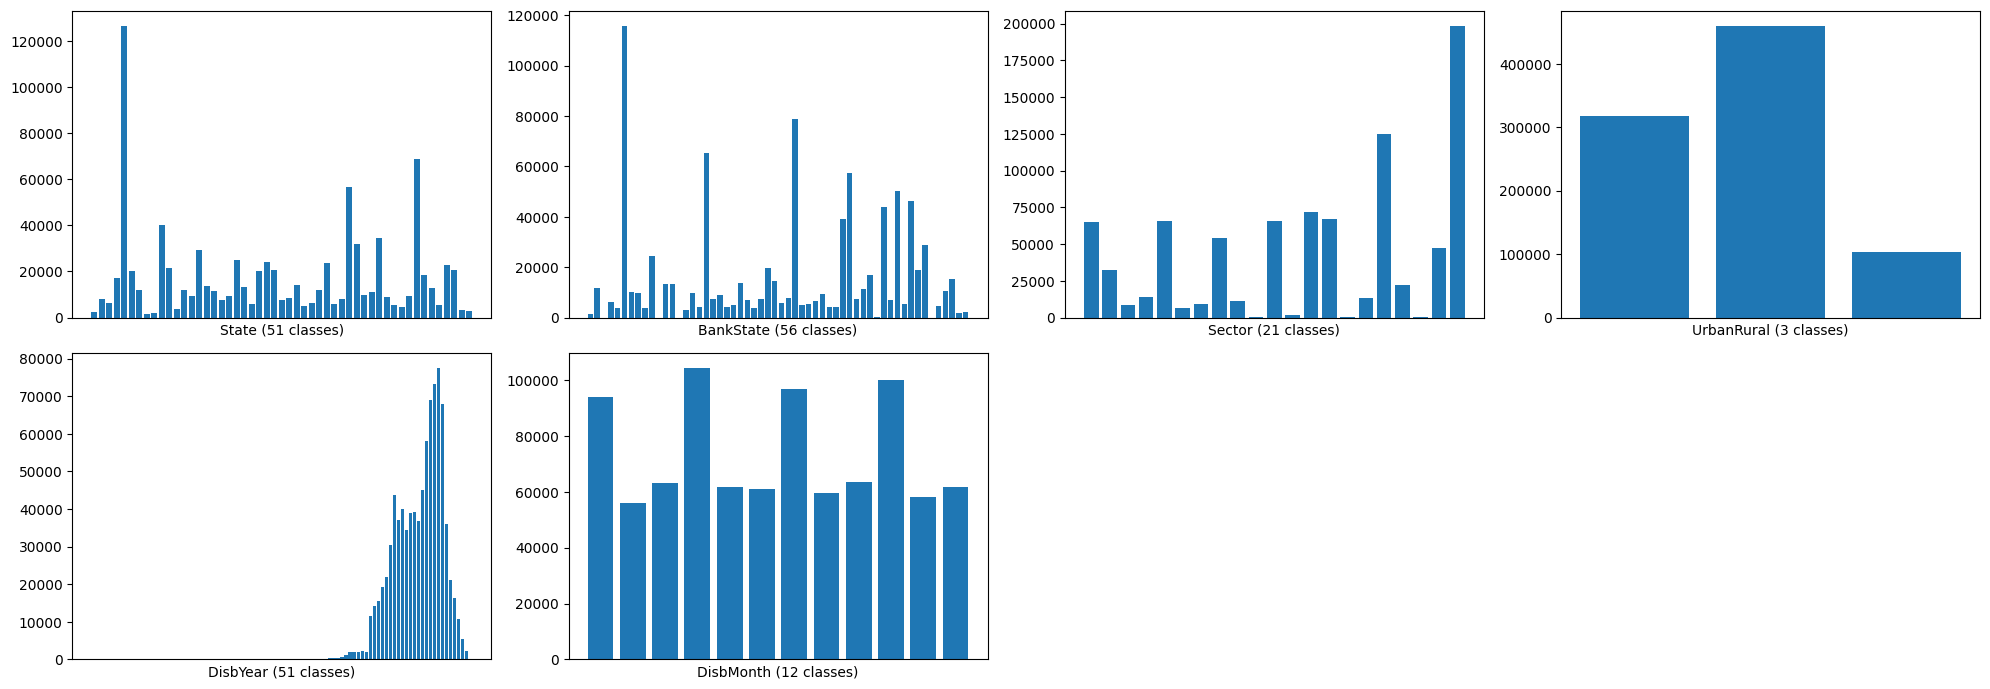

In [60]:
# graficamos la distribucion de los datos de las variables categoricas
plt.figure(figsize=(20,7))
n_rows, n_cols = 2, 4

for num, col in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, num + 1)
    df_ = df.groupby(col)[col].count().reset_index(name="count")
    plt.bar(df_[col], df_["count"])
    col_cls = col + " (" + str(df[col].value_counts().count()) + " classes)"
    plt.xlabel(col_cls)
    plt.xticks([])

plt.tight_layout()
plt.show()

### Standardization

La estandarizacion es util cuando los datos siguen una distribucion normal y queremos tener una media de 0 y una desviacion estandar de 1.

Estandarizar variables depende del modelo a utilizar, como algoritmos que utilizan descenso de gradiente en regresiones o redes neuronales.

Algunos algoritmos, como los arboles de decisión, no se ven afectados por la escala de las variables, por lo que no necesitan estandarizacion.

In [61]:
# aplicaremos estandarizacion solo a modo de ejemplo sobre un dataset clonado
df_ = df.copy()

scaler = StandardScaler()
df_[num_cols] = scaler.fit_transform(df_[num_cols])

media = round(df_["Term"].mean(), 1)
dest = round(df_["Term"].std(), 1)
print(f"Media Term: {media}")
print(f"Desviacion Term: {dest}")
df_[num_cols].sample(3)

Media Term: -0.0
Desviacion Term: 1.0


,Term,NoEmp,CreateJob,RetainedJob,SBA_Secured,DisbGross,GrAppv,SBA_Appv
764826,-0.145437,-0.460654,-0.035220,-0.044462,0.754592,-0.559144,-0.524403,-0.476905
206813,-0.608619,-0.520415,-0.035220,-0.040268,-1.208448,-0.733133,-0.735412,-0.709946
314412,0.292013,0.316248,-0.014224,-0.044462,-1.208448,-0.227848,-0.191644,-0.381063


### Normalization

La normalizacion se refiere a escalar los valores de una variable para que esten en un rango especifico, generalmente entre 0 y 1.

Normalizar variables depende del modelo a utilizar, como algoritmos que utilizan medidas de distancia, como el K-NN o el K-Means.

Algunos algoritmos, como los arboles de decisión, no se ven afectados por la escala de las variables, por lo que no necesitan normalizacion.

In [62]:
# aplicaremos normalizacion solo a modo de ejemplo sobre un dataset clonado
df_ = df.copy()

normalizer = MinMaxScaler()
normalizer_fit = normalizer.fit(df_[num_cols])
df_[num_cols] = normalizer_fit.transform(df_[num_cols])

min = round(df_["Term"].min(), 1)
max = round(df_["Term"].max(), 1)
print(f"Min Term: {min}")
print(f"Max Term: {max}")
df_[num_cols].sample(3)

Min Term: 0.0
Max Term: 1.0


,Term,NoEmp,CreateJob,RetainedJob,SBA_Secured,DisbGross,GrAppv,SBA_Appv
387824,0.605187,0.004292,0.000000,0.0,0.831579,0.144791,0.176221,0.171735
230994,0.691643,0.055794,0.000909,0.0,1.000000,0.435550,0.525832,0.609476
798019,0.172911,0.008584,0.000000,0.0,0.894737,0.018393,0.024239,0.025596


### Encode Features

In [63]:
# Label Encoder: aplicamos a las variables categoricas nominales
label_encoder = LabelEncoder()
for col in cat_cols[:2]:
    df[col] = label_encoder.fit_transform(df[col])

sector_encoder = LabelEncoder()
sector_encoder_fit = sector_encoder.fit(df["Sector"])
df["Sector"] = sector_encoder_fit.transform(df["Sector"])

print(sector_encoder_fit.classes_[0:3])
print(sector_encoder_fit.inverse_transform([4]))
df[cat_cols[:3]].sample(3)

['Accommodation and food services'
 'Administrative and support and waste management and remediation services'
 'Agriculture, forestry, fishing and hunting']
['Construction']


,State,BankState,Sector
122566,43,17,1
153258,33,36,20
490149,35,7,12


In [64]:
# One-Hot Encoder: aplicamos a las variables categoricas numerales
df = pd.get_dummies(df, columns=["UrbanRural"])

df.rename(columns={"UrbanRural_1":"Urban", "UrbanRural_2":"Rural"}, inplace=True)
df.drop(columns="UrbanRural_0", axis=1, inplace=True)

df["Urban"] = df["Urban"].astype(int)
df["Rural"] = df["Rural"].astype(int)
df = df[["State","BankState","StateDiff","Sector","Term","SecuredLoan","NoEmp",
         "NewExist","CreateJob","RetainedJob","Urban","Rural","RevLineCr","LowDoc",
         "DisbYear","DisbMonth", "DisbGross","GrAppv","SBA_Appv","SBA_Secured","Default"]]
df[["Urban","Rural"]].sample(3)

,Urban,Rural
611738,0,0
341018,1,0
792700,0,0


In [65]:
# Ordinal Encoder: aplicamos a las variables categoricas ordinales
ordinal_encoder = OrdinalEncoder(categories=[list(sorted(df["DisbYear"].unique()))])
ordinal_encoder_fit = ordinal_encoder.fit(df[["DisbYear"]])
df["DisbYear"] = ordinal_encoder_fit.transform(df[["DisbYear"]])
df["DisbYear"] = df["DisbYear"].astype(int)

print(ordinal_encoder_fit.categories_)
print(ordinal_encoder_fit.inverse_transform([[44]]))
df[["DisbYear"]].sample(3)

[array([1920, 1928, 1948, 1966, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype=int32)]
[[2008]]


,DisbYear
496746,47
584467,29
778584,31


### Feature Selection

In [66]:
print(df.shape)
df.sample(3)

(880787, 21)


,State,BankState,StateDiff,Sector,Term,SecuredLoan,NoEmp,NewExist,CreateJob,RetainedJob,...,Rural,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
239004,4,30,1,6,40,0,20,0,0,20,...,0,1,0,43,9,86975,35000,17500,50,1
809438,37,5,1,20,84,0,150,0,0,0,...,0,0,0,31,10,157000,157000,109900,70,0
99469,10,30,1,1,63,0,12,0,0,12,...,0,1,0,42,3,149000,100000,50000,50,1


In [67]:
# separamos las features en variables predictoras y variable objetivo
X = df.drop(columns="Default")
y = df.Default

In [68]:
# VarianceThreshold: calculamos la varianza de cada feature (normalizada)
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

var_threshold = VarianceThreshold()
var_threshold_fit = var_threshold.fit(X_)
variances = var_threshold_fit.variances_

threshold = 0.3
variances_th = pd.Series(variances, index=X.columns)
variances_th[variances_th < threshold].sort_values()

RetainedJob    0.000630
CreateJob      0.000732
NoEmp          0.005158
DisbYear       0.013616
DisbGross      0.017021
SBA_Appv       0.022365
GrAppv         0.024392
SBA_Secured    0.033239
Term           0.050170
BankState      0.082112
State          0.091241
DisbMonth      0.097347
Rural          0.103282
LowDoc         0.109186
Sector         0.112654
SecuredLoan    0.135987
RevLineCr      0.184093
NewExist       0.202880
StateDiff      0.249261
Urban          0.249525
dtype: float64

In [69]:
# Mutual Information Analysis: calculamos la relevancia de cada feature
mutual_inf = mutual_info_classif(X, y)

mi_scores = pd.Series(mutual_inf, index=X.columns)
mi_scores.sort_values()

RetainedJob    0.000000
CreateJob      0.000084
Rural          0.005799
NoEmp          0.007161
LowDoc         0.011724
DisbGross      0.013251
GrAppv         0.013442
SBA_Appv       0.013512
NewExist       0.024090
RevLineCr      0.024675
SecuredLoan    0.036916
DisbMonth      0.042783
State          0.044753
BankState      0.046046
Sector         0.069824
SBA_Secured    0.078689
StateDiff      0.079445
Urban          0.087984
DisbYear       0.091040
Term           0.156146
dtype: float64

In [70]:
# Feature Importance Selection: calculamos la importancia de las features
random_forest = RandomForestClassifier(n_estimators=100, random_state=44)
rf_fit = random_forest.fit(X, y)
importance = rf_fit.feature_importances_

results_fis = pd.Series(importance, index=X.columns)
results_fis.sort_values()

LowDoc         0.003495
Rural          0.003867
NewExist       0.008378
SecuredLoan    0.008955
Urban          0.010710
RevLineCr      0.011358
CreateJob      0.014754
RetainedJob    0.025311
StateDiff      0.025603
SBA_Secured    0.026589
DisbMonth      0.028815
Sector         0.029185
NoEmp          0.030666
GrAppv         0.039198
State          0.042321
DisbGross      0.046848
SBA_Appv       0.047311
BankState      0.050720
DisbYear       0.116107
Term           0.429810
dtype: float64

In [71]:
# aplicando los enfoques anteriores eliminamos las features de menor importancia
df = df.drop(columns=["RetainedJob","CreateJob","NoEmp","Rural"])

In [72]:
# vemos una muestra de la version limpia y la almacenamos en un nuevo dataset
print(df.shape)
df.sample(3)

(880787, 17)


,State,BankState,StateDiff,Sector,Term,SecuredLoan,NewExist,Urban,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
661608,21,9,1,17,60,0,1,1,0,0,39,10,54000,54000,27000,50,0
184824,18,37,1,16,120,0,1,0,0,0,35,8,147000,147000,110250,75,0
518816,31,43,1,16,48,0,0,1,1,0,37,12,106882,50000,25000,50,0


In [74]:
df.to_csv("../data/sba_clean.csv", index=False)

## Imbalanced Data

In [76]:
df = pd.read_csv("../data/sba_clean.csv", low_memory=False)
print(df.shape)
print(df["Default"].value_counts())

(880787, 17)
Default
0    724396
1    156391
Name: count, dtype: int64


In [77]:
# separamos las features en variables predictoras y variable objetivo
X = df.drop(columns="Default")
y = df["Default"]

### UnderSampling

In [78]:
undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=44)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

df_under = pd.DataFrame(X_resampled)
df_under["Default"] = y_resampled

print(df_under.shape)
print(df_under["Default"].value_counts())
df_under.sample(3)

(312782, 17)
Default
0    156391
1    156391
Name: count, dtype: int64


,State,BankState,StateDiff,Sector,Term,SecuredLoan,NewExist,Urban,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
583467,10,12,0,12,120,0,1,1,0,0,38,12,265000,265000,198750,75,0
549207,4,5,0,3,60,0,0,0,0,0,38,9,35000,35000,29750,85,0
858622,43,47,0,16,60,0,0,0,0,1,32,11,20000,20000,16000,80,0


### OverSampling

In [79]:
oversampler = RandomOverSampler(sampling_strategy="auto", random_state=44)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_over = pd.DataFrame(X_resampled)
df_over["Default"] = y_resampled

print(df_over.shape)
print(df_over["Default"].value_counts())
df_over.sample(3)

(1448792, 17)
Default
0    724396
1    724396
Name: count, dtype: int64


,State,BankState,StateDiff,Sector,Term,SecuredLoan,NewExist,Urban,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
533414,47,52,0,20,168,0,0,0,0,0,30,4,236000,236000,200600,85,0
1383826,42,5,1,0,50,0,1,1,0,0,43,3,10000,10000,8500,85,1
352528,34,37,0,19,120,0,0,0,0,0,26,1,300000,300000,255000,85,0


### SMOTE: Synthetic Minority Over-Sampling Technique

In [80]:
# aplicamos SMOTE y posteriormente almacenamos el dataset resultante
smote = SMOTE(sampling_strategy="auto", random_state=44)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_smote = pd.DataFrame(X_resampled)
df_smote["Default"] = y_resampled

print(df_smote.shape)
print(df_smote["Default"].value_counts())

(1448792, 17)
Default
0    724396
1    724396
Name: count, dtype: int64


In [81]:
df_smote.to_csv("../data/sba_balanced.csv", index=False)
df_smote.sample(3)

,State,BankState,StateDiff,Sector,Term,SecuredLoan,NewExist,Urban,RevLineCr,LowDoc,DisbYear,DisbMonth,DisbGross,GrAppv,SBA_Appv,SBA_Secured,Default
418375,36,30,1,4,180,0,0,1,0,0,37,2,100000,112500,84375,75,0
830058,14,8,1,20,100,0,0,0,0,0,32,12,440000,440000,330000,75,0
769355,14,17,0,16,84,0,1,0,0,1,31,7,47500,47500,42750,90,0
